In [1]:
import torch
import torchvision
import functools
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm.notebook import trange
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.utils import data
from torchvision.transforms import v2
from torchvision.utils import make_grid
from einops import rearrange
from PIL import Image

In [2]:
def pad_to_square(img):
    width, height = img.size
    max_dim = max(width, height)

    padding = v2.Pad([
        (max_dim - width) // 2,
        (max_dim - height) // 2,
        (max_dim - width + 1) // 2,
        (max_dim - height + 1) // 2
    ])

    return padding(img)

In [3]:
def to_three_channel(img):
    if img.mode != 'RGB':
        return img.convert('RGB')
    return img

In [4]:
def marginal_prob_std(t, sigma, device):
    """
    Compute the mean and standard deviation of p_{0t}(x(t) | x(0)).

    Parameters:
    - t: A vector of time steps.
    - sigma: The sigma in our SDE.

    Returns:
    - The standard deviation.
    """
    # Convert time steps to a PyTorch tensor
    t = t.to(device)

    # Calculate and return the standard deviation based on the given formula
    return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

In [5]:
def diffusion_coeff(t, sigma, device):
    """
    Compute the diffusion coefficient of our SDE.

    Parameters:
    - t: A vector of time steps.
    - sigma: The sigma in our SDE.

    Returns:
    - The vector of diffusion coefficients.
    """
    # Calculate and return the diffusion coefficients based on the given formula
    return (sigma**t).to(device)

In [6]:
def Euler_Maruyama_sampler(score_model,
                           marginal_prob_std,
                           diffusion_coeff,
                           batch_size,
                           num_steps,
                           device,
                           x_shape,
                           eps=1e-3,
                           y=None):
    """
    Generate samples from score-based models with the Euler-Maruyama solver.

    Parameters:
    - score_model: A PyTorch model that represents the time-dependent score-based model.
    - marginal_prob_std: A function that gives the standard deviation of the perturbation kernel.
    - diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    - batch_size: The number of samplers to generate by calling this function once.
    - num_steps: The number of sampling steps, equivalent to the number of discretized time steps.
    - device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    - eps: The smallest time step for numerical stability.
    - y: Target tensor (not used in this function).

    Returns:
    - Samples.
    """

    # Initialize time and the initial sample
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, *x_shape, device=device) * marginal_prob_std(t)[:, None, None, None]

    # Generate time steps
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    x = init_x

    # Sample using Euler-Maruyama method
    with torch.no_grad():
        for time_step in time_steps:
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            g = diffusion_coeff(batch_time_step)
            mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step, y=y) * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)

    # Do not include any noise in the last sampling step.
    return mean_x

In [7]:
def loss_fn_cond(model, x, y, marginal_prob_std, eps=1e-5):
    """The loss function for training score-based generative models with conditional information.

    Parameters:
    - model: A PyTorch model instance that represents a time-dependent score-based model.
    - x: A mini-batch of training data.
    - y: Conditional information (target tensor).
    - marginal_prob_std: A function that gives the standard deviation of the perturbation kernel.
    - eps: A tolerance value for numerical stability.

    Returns:
    - loss: The calculated loss.
    """
    # Sample time uniformly in the range [eps, 1-eps]
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
    # Generate random noise with the same shape as the input
    z = torch.randn_like(x)
    # Compute the standard deviation of the perturbation kernel at the sampled time
    std = marginal_prob_std(random_t)
    # Perturb the input data with the generated noise and scaled by the standard deviation
    perturbed_x = x + z * std[:, None, None, None]
    # Get the model's score for the perturbed input, considering conditional information
    score = model(perturbed_x, random_t, y=y)
    # Calculate the loss using the score and perturbation
    loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1, 2, 3)))
    return loss

In [8]:
class PokemonDataset(data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.labels_df = pd.read_csv(data_dir / 'pokemon.csv')
        self.img_dir = data_dir / 'images'
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        if isinstance(idx, int):
            img_path = self.img_dir / (self.labels_df.iloc[idx, 0] + '.png')
            image = Image.open(img_path).convert("RGB")
            idx_to_class = dict(enumerate(self.labels_df.iloc[:, 1].unique()))
            class_to_idx = {value: key for key, value in idx_to_class.items()}
            label = class_to_idx[self.labels_df.iloc[idx, 1]]

            if self.transform:
                image = self.transform(image)

            return image, label
        
    def get_labels(self):
        return self.labels_df.iloc[:, 1].unique()

In [9]:
class GaussianFourierProjection(nn.Module):
# Define a module for Gaussian random features used to encode time steps.
    def __init__(self, embed_dim, scale=30.):
        """
        Parameters:
        - embed_dim: Dimensionality of the embedding (output dimension)
        - scale: Scaling factor for random weights (frequencies)
        """
        super().__init__()

        # Randomly sample weights (frequencies) during initialization.
        # These weights (frequencies) are fixed during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)

    def forward(self, x):
        """
        Parameters:
        - x: Input tensor representing time steps
        """
        # Calculate the cosine and sine projections: Cosine(2 pi freq x), Sine(2 pi freq x)
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi

        # Concatenate the sine and cosine projections along the last dimension
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

In [10]:
class Dense(nn.Module):
# Define a module for a fully connected layer that reshapes outputs to feature maps.
    def __init__(self, input_dim, output_dim):
        """
        Parameters:
        - input_dim: Dimensionality of the input features
        - output_dim: Dimensionality of the output features
        """
        super().__init__()

        # Define a fully connected layer
        self.dense = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        """
        Parameters:
        - x: Input tensor

        Returns:
        - Output tensor after passing through the fully connected layer
          and reshaping to a 4D tensor (feature map)
        """

        # Apply the fully connected layer and reshape the output to a 4D tensor
        return self.dense(x)[..., None, None]
        # This broadcasts the 2D tensor to a 4D tensor, adding the same value across space.

In [11]:
class CrossAttention(nn.Module):
    def __init__(self, embed_dim, hidden_dim, context_dim=None):
        """
        Initialize the CrossAttention module.

        Parameters:
        - embed_dim: The dimensionality of the output embeddings.
        - hidden_dim: The dimensionality of the hidden representations.
        - context_dim: The dimensionality of the context representations (if not self attention).

        Note: For simplicity reasons, the implementation assumes 1-head attention.
        Feel free to implement multi-head attention using fancy tensor manipulations.
        """
        super(CrossAttention, self).__init__()

        self.hidden_dim = hidden_dim
        self.context_dim = context_dim
        self.embed_dim = embed_dim

        # Linear layer for query projection
        self.query = nn.Linear(hidden_dim, embed_dim, bias=False)
        
        # Check if self-attention or cross-attention
        if context_dim is None:
            self.self_attn = True
            self.key = nn.Linear(hidden_dim, embed_dim, bias=False)
            self.value = nn.Linear(hidden_dim, hidden_dim, bias=False)
        else:
            self.self_attn = False
            self.key = nn.Linear(context_dim, embed_dim, bias=False)
            self.value = nn.Linear(context_dim, hidden_dim, bias=False)

    def forward(self, tokens, context=None):
        """
        Forward pass of the CrossAttention module.

        Parameters:
        - tokens: Input tokens with shape [batch, sequence_len, hidden_dim].
        - context: Context information with shape [batch, context_seq_len, context_dim].
                   If self_attn is True, context is ignored.

        Returns:
        - ctx_vecs: Context vectors after attention with shape [batch, sequence_len, embed_dim].
        """

        if self.self_attn:
            # Self-attention case
            Q = self.query(tokens)
            K = self.key(tokens)
            V = self.value(tokens)
        else:
            # Cross-attention case
            Q = self.query(tokens)
            K = self.key(context)
            V = self.value(context)

        # Compute score matrices, attention matrices, and context vectors
        scoremats = torch.einsum("BTH,BSH->BTS", Q, K)  # Inner product of Q and K, a tensor
        attnmats = nn.functional.softmax(scoremats / math.sqrt(self.embed_dim), dim=-1)  # Softmax of scoremats
        ctx_vecs = torch.einsum("BTS,BSH->BTH", attnmats, V)  # Weighted average value vectors by attnmats

        return ctx_vecs

In [12]:
class TransformerBlock(nn.Module):
    """The transformer block that combines self-attn, cross-attn, and feed forward neural net"""
    def __init__(self, hidden_dim, context_dim):
        """
        Initialize the TransformerBlock.

        Parameters:
        - hidden_dim: The dimensionality of the hidden state.
        - context_dim: The dimensionality of the context tensor.

        Note: For simplicity, the self-attn and cross-attn use the same hidden_dim.
        """

        super(TransformerBlock, self).__init__()

        # Self-attention module
        self.attn_self = CrossAttention(hidden_dim, hidden_dim)

        # Cross-attention module
        self.attn_cross = CrossAttention(hidden_dim, hidden_dim, context_dim)

        # Layer normalization modules
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.norm3 = nn.LayerNorm(hidden_dim)

        # Implement a 2-layer MLP with K * hidden_dim hidden units, and nn.GELU nonlinearity
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, 3 * hidden_dim),
            nn.GELU(),
            nn.Linear(3 * hidden_dim, hidden_dim)
        )

    def forward(self, x, context=None):
        """
        Forward pass of the TransformerBlock.

        Parameters:
        - x: Input tensor with shape [batch, sequence_len, hidden_dim].
        - context: Context tensor with shape [batch, context_seq_len, context_dim].

        Returns:
        - x: Output tensor after passing through the TransformerBlock.
        """

        # Apply self-attention with layer normalization and residual connection
        x = self.attn_self(self.norm1(x)) + x

        # Apply cross-attention with layer normalization and residual connection
        x = self.attn_cross(self.norm2(x), context=context) + x

        # Apply feed forward neural network with layer normalization and residual connection
        x = self.ffn(self.norm3(x)) + x

        return x

In [13]:
class SpatialTransformer(nn.Module):
    def __init__(self, hidden_dim, context_dim):
        """
        Initialize the SpatialTransformer.

        Parameters:
        - hidden_dim: The dimensionality of the hidden state.
        - context_dim: The dimensionality of the context tensor.
        """
        super(SpatialTransformer, self).__init__()
        
        # TransformerBlock for spatial transformation
        self.transformer = TransformerBlock(hidden_dim, context_dim)

    def forward(self, x, context=None):
        """
        Forward pass of the SpatialTransformer.

        Parameters:
        - x: Input tensor with shape [batch, channels, height, width].
        - context: Context tensor with shape [batch, context_seq_len, context_dim].

        Returns:
        - x: Output tensor after applying spatial transformation.
        """
        b, c, h, w = x.shape
        x_in = x

        # Combine the spatial dimensions and move the channel dimension to the end
        x = rearrange(x, "b c h w -> b (h w) c")

        # Apply the sequence transformer
        x = self.transformer(x, context)

        # Reverse the process
        x = rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)

        # Residue connection
        return x + x_in

In [14]:
class UNet_Tranformer(nn.Module):
    """A time-dependent score-based model built upon U-Net architecture."""

    def __init__(self, marginal_prob_std, x_shape, n_classes, channels=[32, 64, 128, 256], embed_dim=256, text_dim=256):
        """
        Initialize a time-dependent score-based network.

        Parameters:
        - marginal_prob_std: A function that takes time t and gives the standard deviation
          of the perturbation kernel p_{0t}(x(t) | x(0)).
        - channels: The number of channels for feature maps of each resolution.
        - embed_dim: The dimensionality of Gaussian random feature embeddings of time.
        - text_dim: The embedding dimension of text/digits.
        - n_classes: Number of classes to model.
        """
        super().__init__()

        # Gaussian random feature embedding layer for time
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim)
        )

        # Encoding layers where the resolution decreases
        self.conv1 = nn.Conv2d(in_channels=x_shape[0], out_channels=channels[0], kernel_size=3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(num_groups=4, num_channels=channels[0])

        self.conv2 = nn.Conv2d(in_channels=channels[0], out_channels=channels[1], kernel_size=3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(num_groups=32, num_channels=channels[1])

        self.conv3 = nn.Conv2d(in_channels=channels[1], out_channels=channels[2], kernel_size=3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(num_groups=32, num_channels=channels[2])
        self.attn3 = SpatialTransformer(channels[2], text_dim)

        self.conv4 = nn.Conv2d(in_channels=channels[2], out_channels=channels[3], kernel_size=3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(num_groups=32, num_channels=channels[3])
        self.attn4 = SpatialTransformer(channels[3], text_dim)

        # Decoding layers where the resolution increases
        self.tconv4 = nn.ConvTranspose2d(in_channels=channels[3], out_channels=channels[2], kernel_size=3, stride=2, bias=False,  output_padding=1)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(num_groups=32, num_channels=channels[2])

        self.tconv3 = nn.ConvTranspose2d(in_channels=channels[2], out_channels=channels[1], kernel_size=3, stride=2, bias=False, output_padding=1)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(num_groups=32, num_channels=channels[1])

        self.tconv2 = nn.ConvTranspose2d(in_channels=channels[1], out_channels=channels[0], kernel_size=3, stride=2, bias=False, output_padding=1)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(num_groups=32, num_channels=channels[0])

        self.tconv1 = nn.ConvTranspose2d(in_channels=channels[0], out_channels=x_shape[0], kernel_size=3, stride=1)

        # The swish activation function
        self.act = nn.SiLU()
        self.marginal_prob_std = marginal_prob_std
        self.cond_embed = nn.Embedding(n_classes, text_dim)

    def forward(self, x, t, y=None):
        """
        Forward pass of the UNet_Transformer model.

        Parameters:
        - x: Input tensor.
        - t: Time tensor.
        - y: Target tensor.

        Returns:
        - h: Output tensor after passing through the UNet_Transformer architecture.
        """
        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.time_embed(t))
        y_embed = self.cond_embed(y).unsqueeze(1)

        # Encoding path
        h1 = self.conv1(x) + self.dense1(embed)
        h1 = self.act(self.gnorm1(h1))
        h2 = self.conv2(h1) + self.dense2(embed)
        h2 = self.act(self.gnorm2(h2))
        h3 = self.conv3(h2) + self.dense3(embed)
        h3 = self.act(self.gnorm3(h3))
        h3 = self.attn3(h3, y_embed)
        h4 = self.conv4(h3) + self.dense4(embed)
        h4 = self.act(self.gnorm4(h4))
        h4 = self.attn4(h4, y_embed)

        # Decoding path
        h = self.tconv4(h4) + self.dense5(embed)
        h = self.act(self.tgnorm4(h))
        h = self.tconv3(h + h3) + self.dense6(embed)
        h = self.act(self.tgnorm3(h))
        h = self.tconv2(h + h2) + self.dense7(embed)
        h = self.act(self.tgnorm2(h))
        h = self.tconv1(h + h1)

        # Normalize output
        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h

In [15]:
is_training = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 64
n_epochs = 50
learning_rate = 1e-3

sigma = 25.0
sampler_steps = 250
sample_batch_size = 9

marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma, device=device)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma, device=device)

data_path = Path.cwd() / 'data'
Path(data_path).mkdir(parents=True, exist_ok=True)

model_path = Path.cwd() / 'models'
Path(model_path).mkdir(parents=True, exist_ok=True)

In [16]:
## Pokemon
img_dim = 64
dataset = PokemonDataset(data_dir=data_path / 'Pokemon', transform=v2.Compose([v2.Lambda(pad_to_square),
                                                                               v2.Lambda(to_three_channel),
                                                                               v2.Resize(size=(img_dim, img_dim)),
                                                                               v2.ToImage(),
                                                                               v2.ToDtype(torch.float32, scale=True)]))
data_loader = data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

n_classes = len(dataset.get_labels())
x_shape = dataset[0][0].shape
idx_to_class = dict(enumerate(dataset.get_labels()))
class_to_idx = {value: key for key, value in idx_to_class.items()}

dataset_name = 'Pokemon'

In [17]:
## MNIST
# img_dim = 32
# dataset = torchvision.datasets.MNIST(root=data_path, transform=v2.Compose([v2.Lambda(pad_to_square),
#                                                                            v2.Lambda(to_three_channel),
#                                                                            v2.Resize(size=(img_dim, img_dim)),
#                                                                            v2.ToImage(),
#                                                                            v2.ToDtype(torch.float32, scale=True)]),
#                                                                            download=True)
# data_loader = data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# n_classes = len(dataset.classes)
# x_shape = dataset[0][0].shape
# idx_to_class = dict(enumerate(dataset.classes))
# class_to_idx = {value: key for key, value in idx_to_class.items()}

# dataset_name = 'MNIST'

In [18]:
## Fashion MNIST
# img_dim = 32
# dataset = torchvision.datasets.FashionMNIST(root=data_path, transform=v2.Compose([v2.Lambda(pad_to_square),
#                                                                                   v2.Lambda(to_three_channel),
#                                                                                   v2.Resize(size=(img_dim, img_dim)),
#                                                                                   v2.ToImage(),
#                                                                                   v2.ToDtype(torch.float32, scale=True)]),
#                                                                                   download=True)
# data_loader = data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# n_classes = len(dataset.classes)
# x_shape = dataset[0][0].shape
# idx_to_class = dict(enumerate(dataset.classes))
# class_to_idx = {value: key for key, value in idx_to_class.items()}

# dataset_name = 'FashionMNIST'

In [19]:
## CIFAR10
# img_dim = 32
# dataset = torchvision.datasets.CIFAR10(root=data_path, transform=v2.Compose([v2.Lambda(pad_to_square),
#                                                                              v2.Lambda(to_three_channel),
#                                                                              v2.Resize(size=(img_dim, img_dim)),
#                                                                              v2.ToImage(),
#                                                                              v2.ToDtype(torch.float32, scale=True)]),
#                                                                              download=True)
# data_loader = data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# n_classes = len(dataset.classes)
# x_shape = dataset[0][0].shape
# idx_to_class = dict(enumerate(dataset.classes))
# class_to_idx = {value: key for key, value in idx_to_class.items()}

# dataset_name = 'CIFAR10'

In [20]:
## Caltech256
# img_dim = 64
# dataset = torchvision.datasets.Caltech256(root=data_path, transform=v2.Compose([v2.Lambda(pad_to_square),
#                                                                                 v2.Lambda(to_three_channel),
#                                                                                 v2.Resize(size=(img_dim, img_dim)),
#                                                                                 v2.ToImage(),
#                                                                                 v2.ToDtype(torch.float32, scale=True)]),
#                                                                                 download=True)
# data_loader = data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# n_classes = len(dataset.categories)
# x_shape = dataset[0][0].shape
# idx_to_class = dict(enumerate([name.split('.')[-1] for name in dataset.categories]))
# class_to_idx = {value: key for key, value in idx_to_class.items()}

# dataset_name = 'Caltech256'

0
Grass
torch.Size([64, 64, 3])


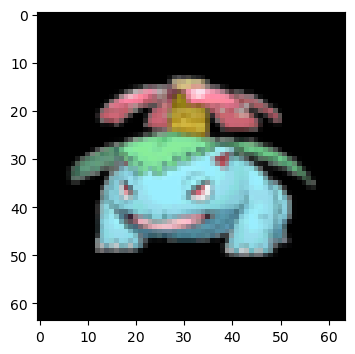

In [21]:
testing_idx = 2
print(dataset[testing_idx][1])
print(idx_to_class[dataset[testing_idx][1]])
print(dataset[testing_idx][0].permute(1, 2, 0).shape)
plt.figure(figsize=(4, 4))
plt.imshow(dataset[testing_idx][0].permute(1, 2, 0))
plt.show()

In [22]:
## preview dataset
# unique_images, unique_labels = next(iter(data_loader))

# fig, axes = plt.subplots(4, 4, figsize=(8, 8), sharex=True, sharey=True)

# for i in range(4): 
#     for j in range(4):
#         index = i * 4 + j
#         axes[i, j].imshow(unique_images[index].permute(1, 2, 0))
#         axes[i, j].axis('off')

# plt.show()

In [23]:
if is_training:
    model = nn.DataParallel(UNet_Tranformer(marginal_prob_std=marginal_prob_std_fn, x_shape=x_shape, n_classes=n_classes)).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    # scheduler = lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=1) # used to keep contant LR
    # scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer=optimizer, T_0=n_epochs // 5)
    scheduler = lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=learning_rate, epochs=n_epochs, steps_per_epoch=len(data_loader))

    tqdm_epochs = trange(n_epochs)
    for epoch in tqdm_epochs:
        for x, y in data_loader:
            x = x.to(device)
            optimizer.zero_grad()
            loss = loss_fn_cond(model, x, y, marginal_prob_std=marginal_prob_std_fn)
            loss.backward()
            optimizer.step()
            scheduler.step()

        if n_epochs <= 20 or epoch % (n_epochs // 20) == 0 or epoch == 0 or epoch == n_epochs - 1:
            print('loss:', loss.item())
            print('lr:', scheduler.get_last_lr()[0])

    model_file_name = f'{batch_size}_{n_epochs}_{learning_rate}_{n_classes}_{img_dim}_{dataset_name}-OneCycleLR.pt'
    torch.save(model.state_dict(), model_path / model_file_name)

else:
    model_file_name = '4_2000_0.001_18_64_Pokemon-OneCycleLR.pt'

    n_classes = int(model_file_name.split('_')[-3])
    img_dim = int(model_file_name.split('_')[-2])

    model = nn.DataParallel(UNet_Tranformer(marginal_prob_std=marginal_prob_std_fn, x_shape=x_shape, n_classes=n_classes)).to(device)
    model.load_state_dict(torch.load(model_path / model_file_name, weights_only=True))

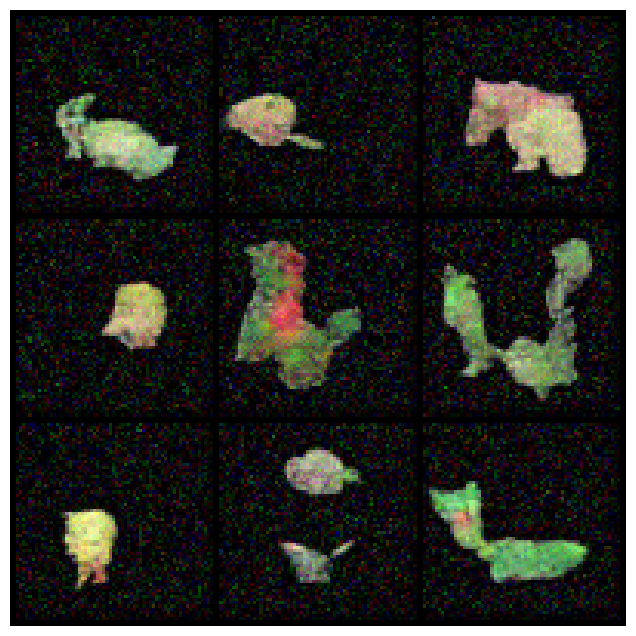

In [24]:
idx = class_to_idx['Grass']

samples = Euler_Maruyama_sampler(score_model=model,
                                 marginal_prob_std=marginal_prob_std_fn,
                                 diffusion_coeff=diffusion_coeff_fn,
                                 batch_size=sample_batch_size,
                                 num_steps=sampler_steps,
                                 device=device,
                                 x_shape=x_shape,
                                 y=idx*torch.ones(sample_batch_size, dtype=torch.long)).clamp(0., 1.)

sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

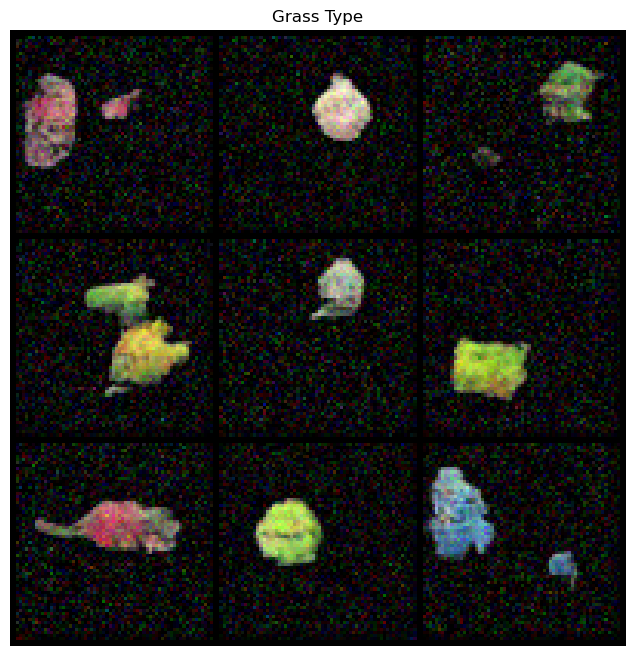

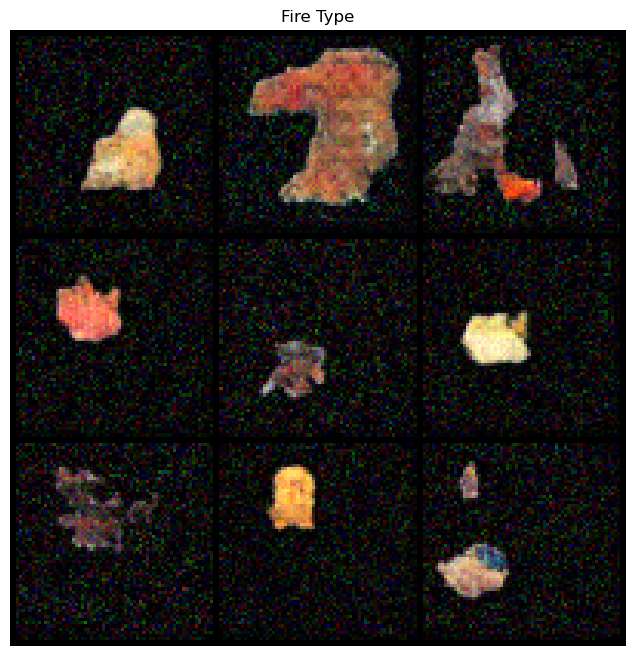

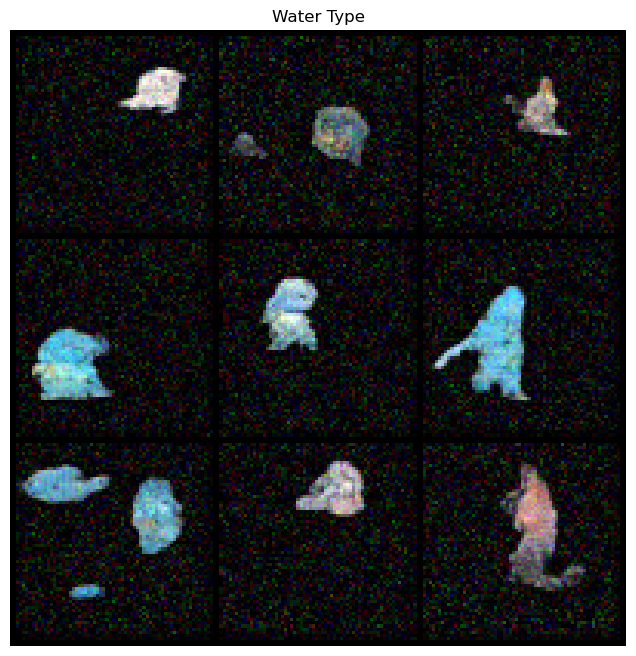

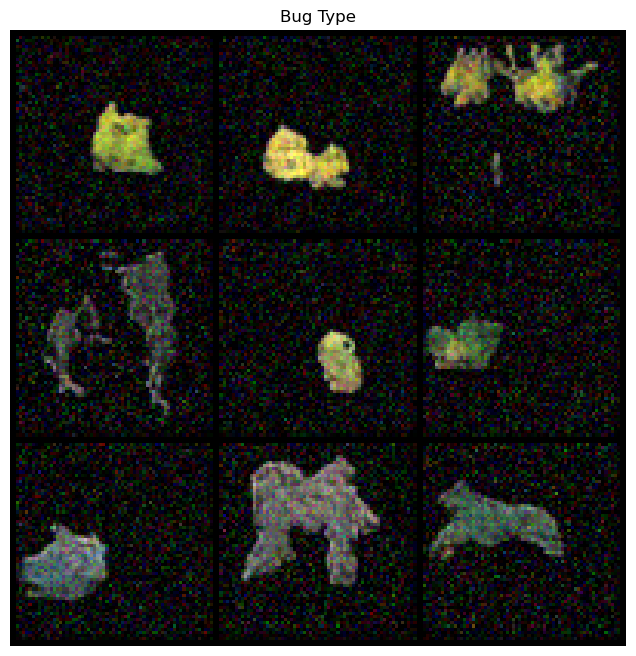

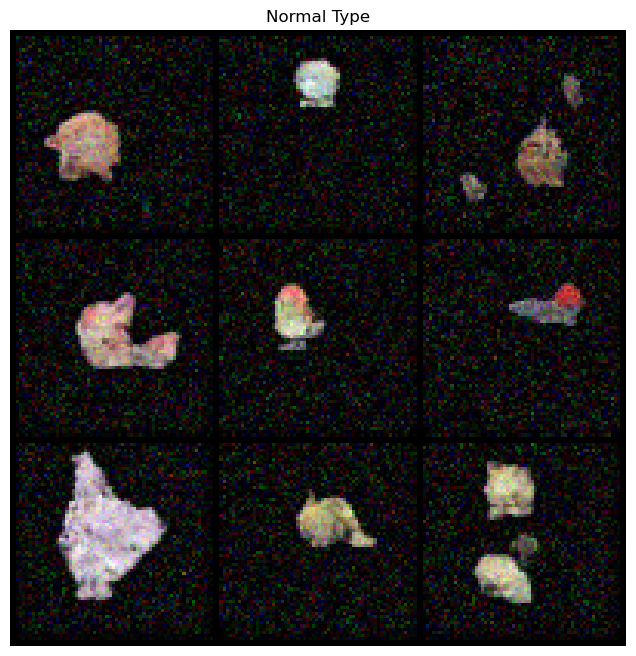

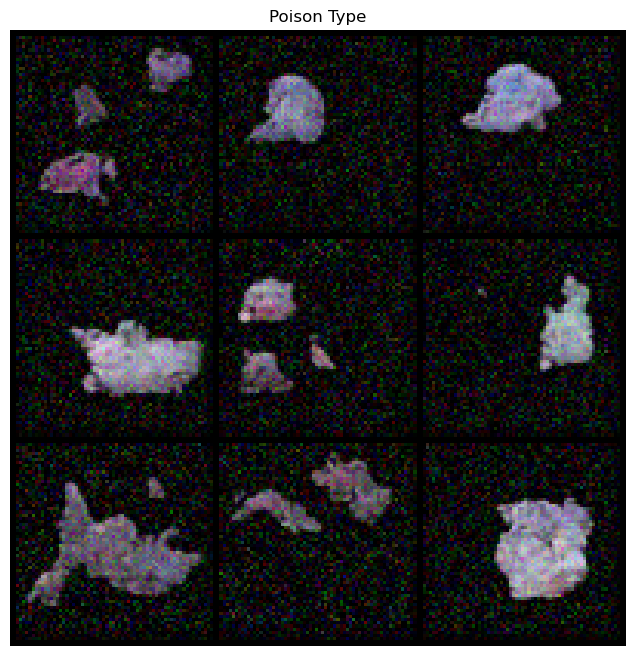

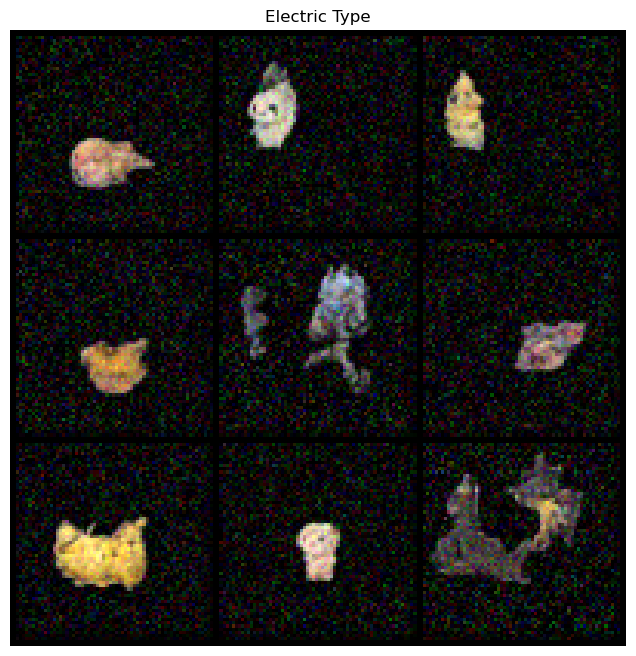

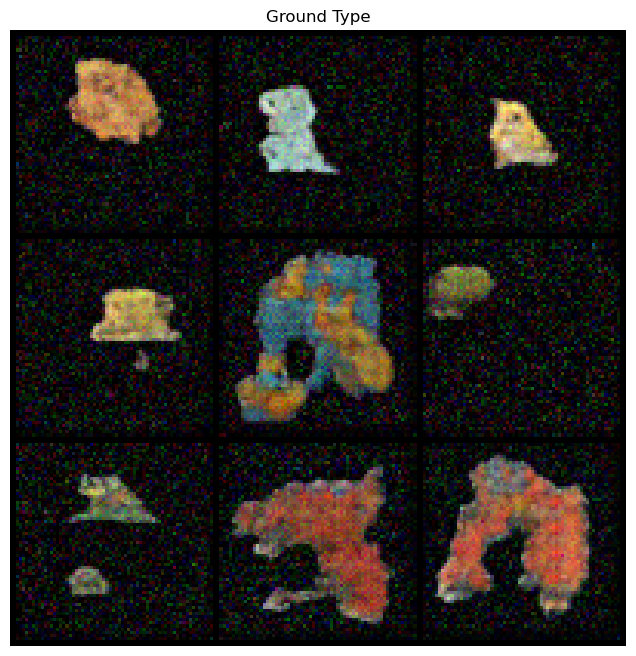

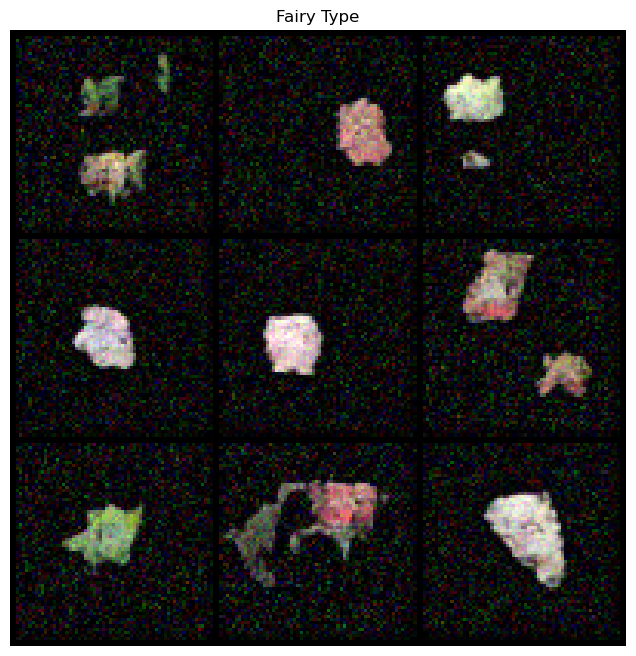

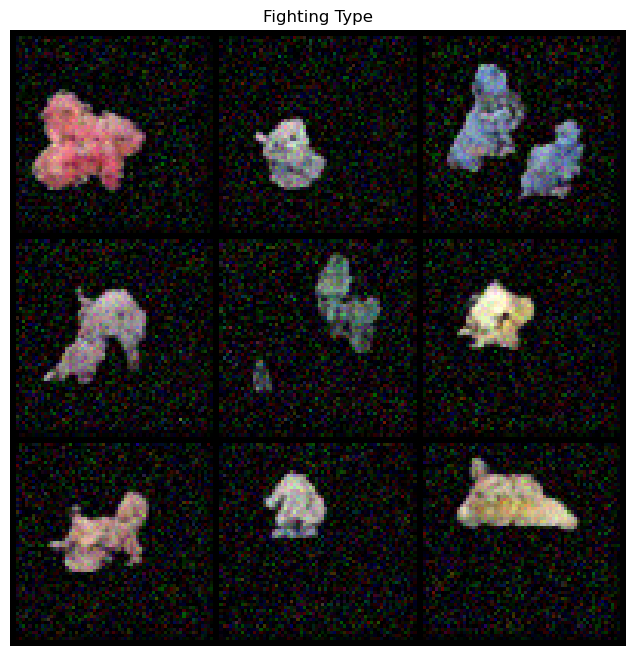

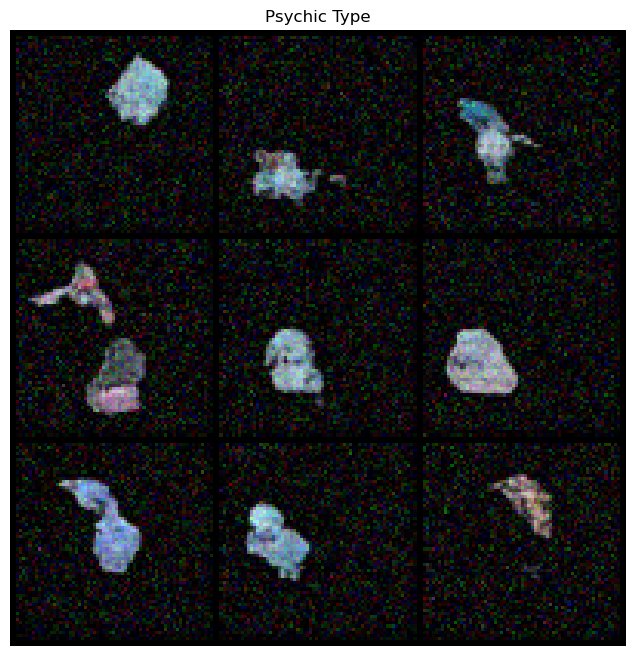

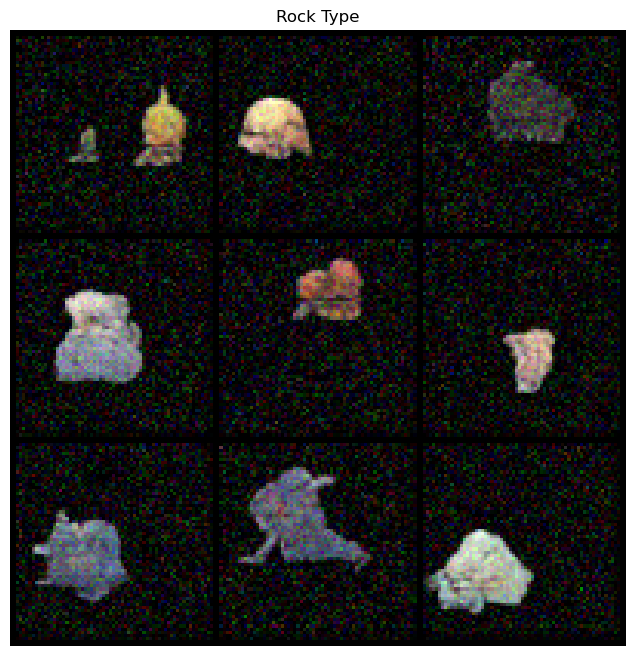

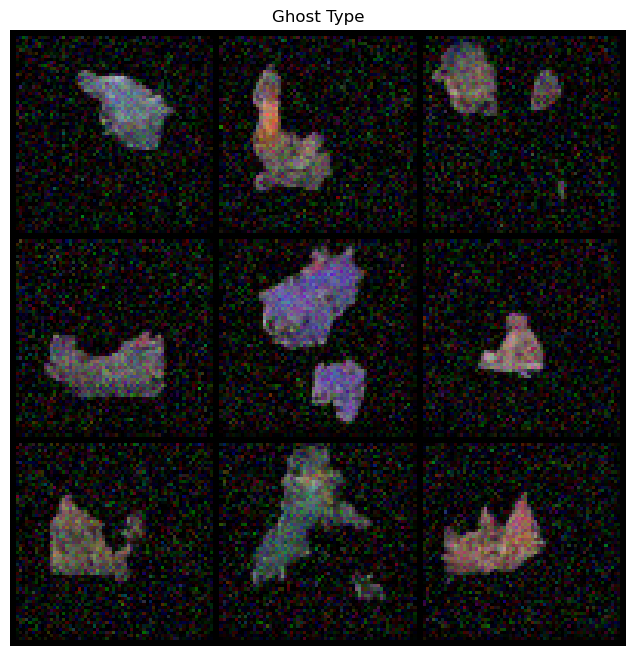

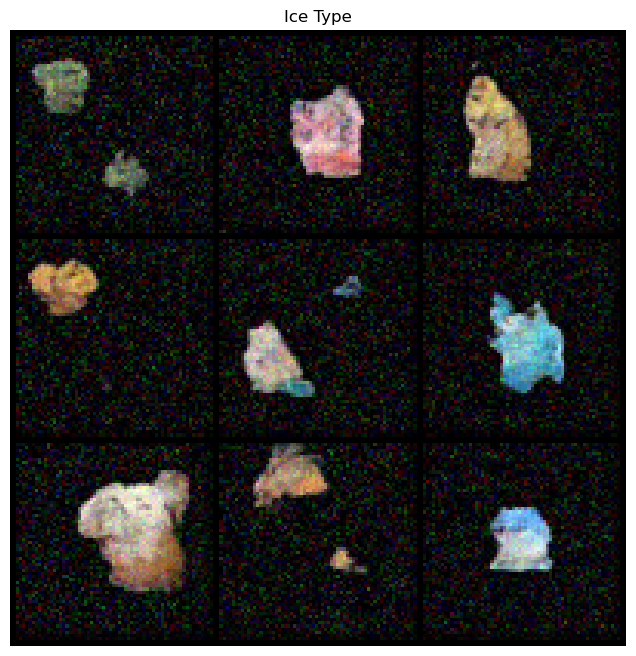

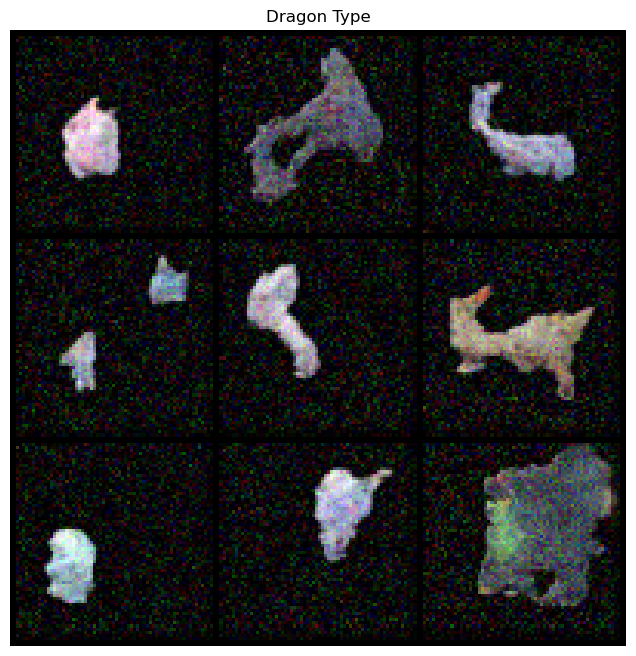

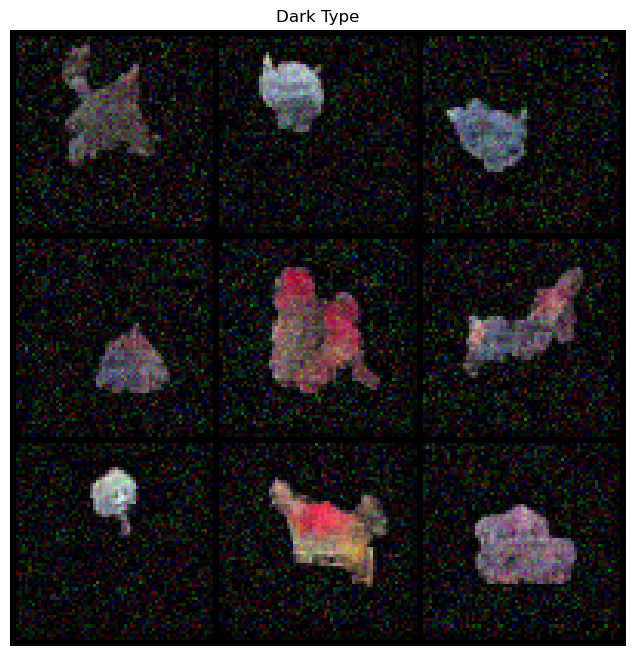

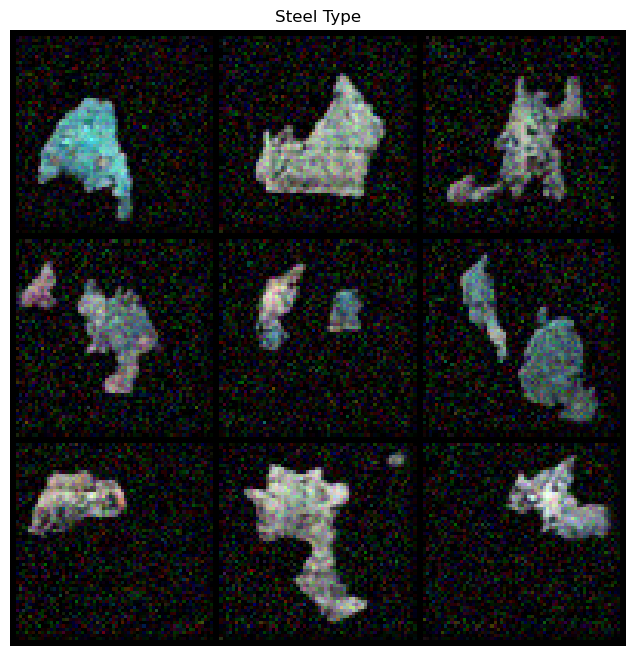

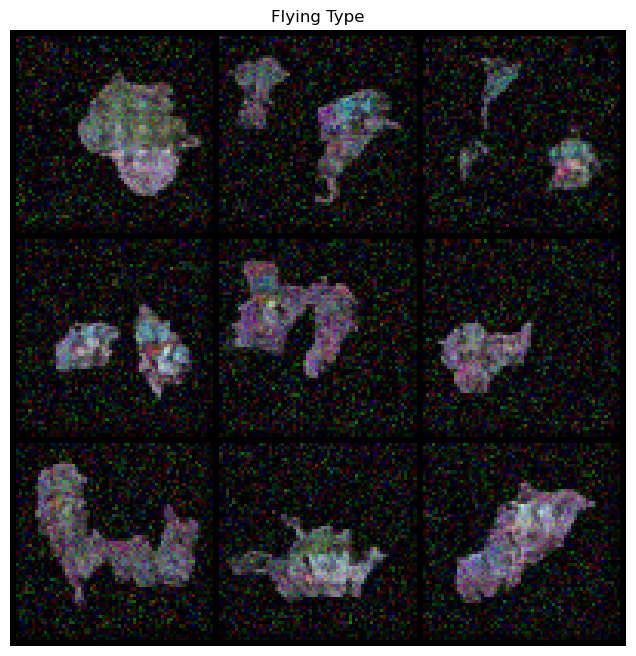

In [25]:
for idx in idx_to_class:
    samples = Euler_Maruyama_sampler(score_model=model,
                                     marginal_prob_std=marginal_prob_std_fn,
                                     diffusion_coeff=diffusion_coeff_fn,
                                     batch_size=sample_batch_size,
                                     num_steps=sampler_steps,
                                     device=device,
                                     x_shape=x_shape,
                                     y=idx*torch.ones(sample_batch_size, dtype=torch.long)).clamp(0., 1.)

    sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
    plt.title(f"{idx_to_class[idx]} Type")
    plt.show()